In [2]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import pymysql
pymysql.install_as_MySQLdb()
from sqlalchemy import Column, Integer, String, Float

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

##### Inspect Tables

In [11]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

## Precipitaion Analysis

#### Design a query to retrieve the last 12 months of precipitation data and plot the results


In [14]:
conn = engine.connect()
measurement_data = pd.read_sql("SELECT * FROM measurement", conn)
measurement_data.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


#### Calculate the date 1 year ago from today

In [15]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [16]:
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

NameError: name 'query_date' is not defined

#### Filter for percipitation in last 12 months


In [18]:
prcp_stmt = session.query( Measurement.prcp,Measurement.date ).\
     filter(Measurement.date >year_ago).\
     order_by(Measurement.date).statement
prcp_12_mon = pd.read_sql_query(prcp_stmt, session.bind)
prcp_12_mon.set_index('date', inplace=True)

#### Use Pandas Plotting with Matplotlib to plot the data

<IPython.core.display.Javascript object>


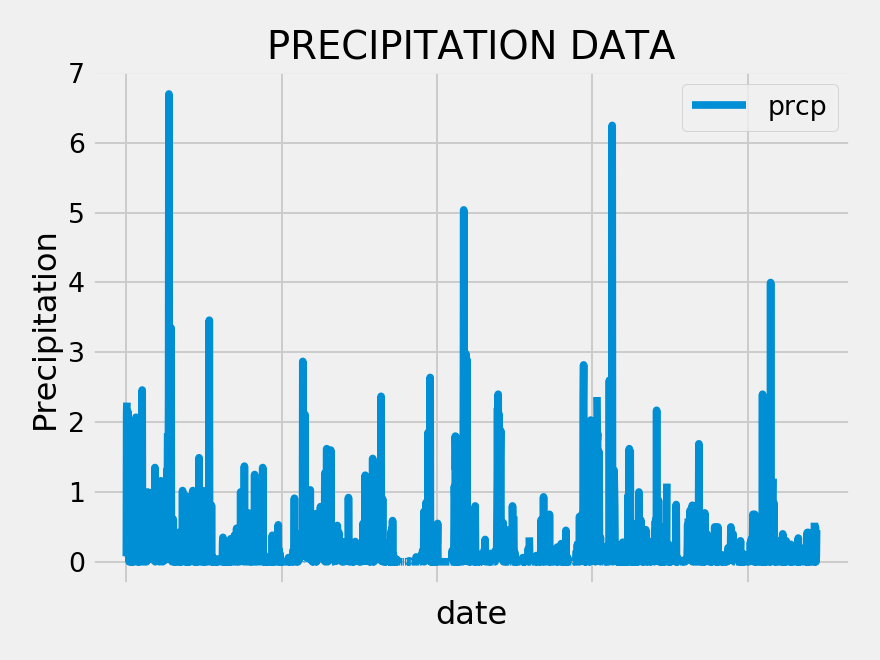

In [19]:
#plotting the Precipitation by date 
ppt_plot = prcp_12_mon.plot(grid=True,title="PRECIPITATION DATA")
plt.ylabel("Precipitation")
plt.tight_layout()
plt.show()

#### Summary statistics for the precipitation data

In [20]:
prcp_12_mon.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [21]:
conn = engine.connect()
station_data = pd.read_sql("SELECT * FROM station", conn)
station_data.head(10)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


#### How many stations are available in this dataset?


In [22]:
stations = session.query(Station).group_by(Station.station).count()
print(stations)

9


In [91]:
session.query(Measurement.station, func.count(Measurement.tobs)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

#### Temperature Analysis

In [23]:
session.query(Measurement.station, func.count(Measurement.tobs)).\
group_by(Measurement.station)

In [24]:
high_temp = session.query(func.max(Measurement.tobs)).\
            filter(Measurement.station == "USC00519281").all()
low_temp = session.query(func.min(Measurement.tobs)).\
            filter(Measurement.station == "USC00519281").all()
avg_temp = session.query(func.avg(Measurement.tobs)).\
            filter(Measurement.station == "USC00519281").all()
print(f" Most active station: the highest temperature: {high_temp}, lowest temperature: {low_temp}, average temperature: {avg_temp}")

 Most active station: the highest temperature: [(85.0,)], lowest temperature: [(54.0,)], average temperature: [(71.66378066378067,)]


In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stmt = session.query(Measurement.date, Measurement.tobs ).\
     filter(Measurement.date >year_ago).\
     filter(Measurement.station=="USC00519281").\
     order_by(Measurement.date).statement

active_station = pd.read_sql_query(stmt, session.bind)
active_station.set_index('date', inplace=True)
active_station.head(10)

,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
2016-08-29,78.0
2016-08-30,77.0
2016-08-31,78.0
2016-09-01,80.0


<IPython.core.display.Javascript object>


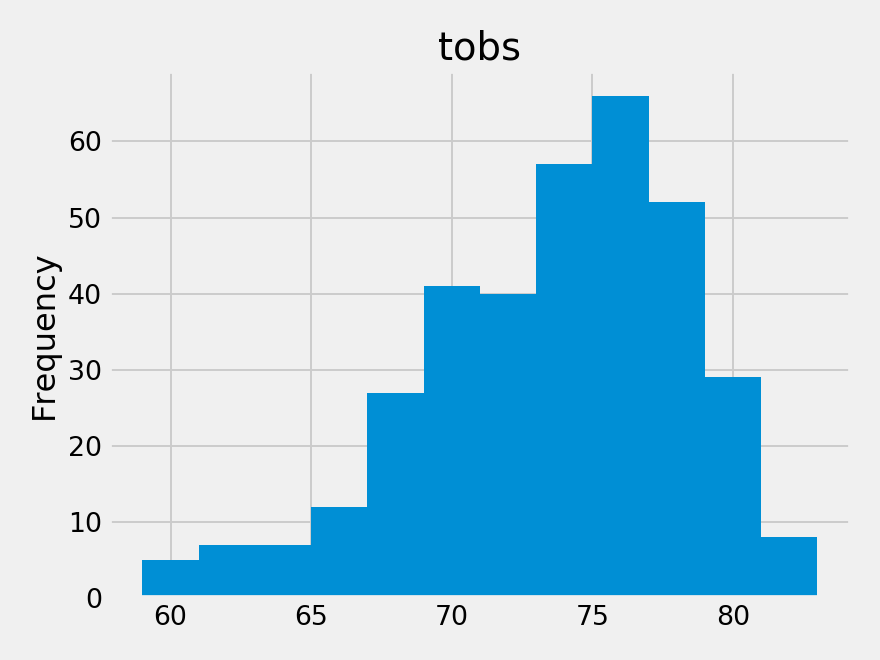

In [26]:
histogram=active_station.hist(column='tobs', bins=12)
# plt.title("Active station Temperature Frequency ")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

![station-histogram](Images/station-histogram.png)

In [27]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
Hawaii=calc_temps('2012-02-28', '2012-03-05')
print(" Analysis for My Hawaii trip date:'2017-01-01', '2017-01-12'")
print("-"*50)
print(f" The Minimum temperatures is {Hawaii[0][0]}.")
print(f" The Maximum temperatures is {Hawaii[0][2]}.")
print(f" The Avarag temperatures is {Hawaii[0][1]}.")
print(calc_temps('2017-01-01', '2017-01-12'))

 Analysis for My Hawaii trip date:'2017-01-01', '2017-01-12'
--------------------------------------------------
 The Minimum temperatures is 62.0.
 The Maximum temperatures is 74.0.
 The Avarag temperatures is 69.57142857142857.
[(60.0, 68.23287671232876, 81.0)]


In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
import numpy as np

results=session.query(Measurement.tobs).\
     filter(Measurement.date >year_ago).\
     filter(Measurement.station=="USC00519281").all()


ptps = list(np.ravel(results))

<IPython.core.display.Javascript object>


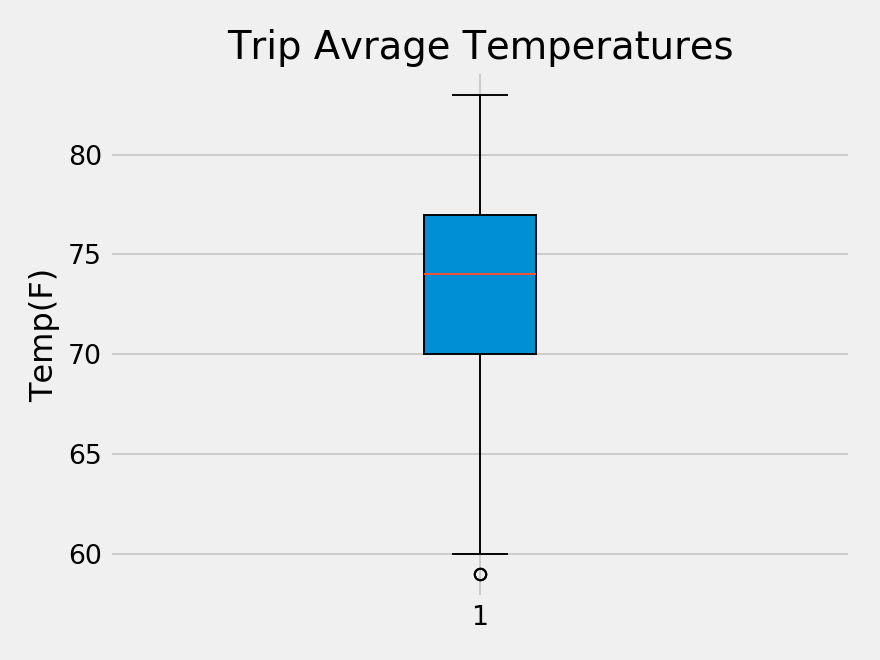

In [31]:
fig, ax = plt.subplots()

x = range(len(ptps))
ax.boxplot(ptps, patch_artist=True)
ax.set_title('Trip Avrage Temperatures')
ax.set_ylabel("Temp(F)")

fig.tight_layout()
plt.show()

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


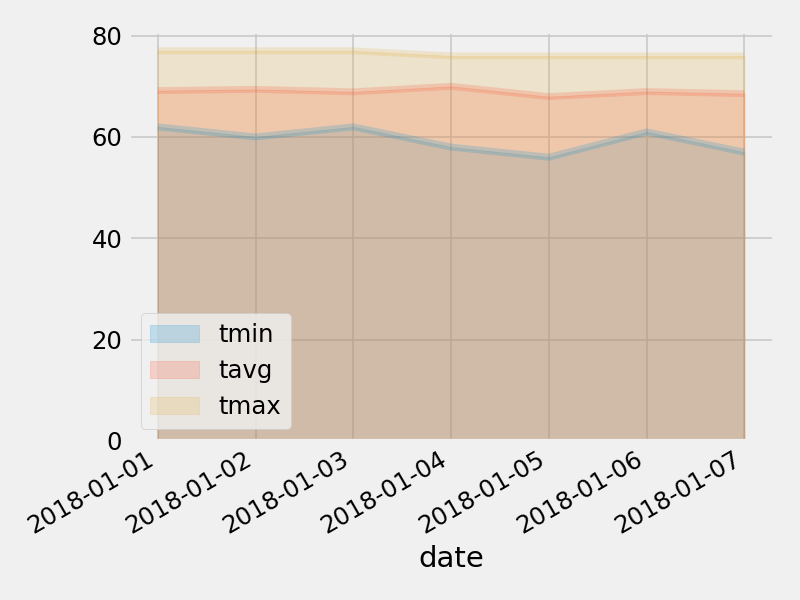

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
